#LogoNet: A Robust Layer-Aggregated Dual-Attention Anchorfree Logo Detection Framework with an Adversarial Domain Adaptation Approach

##Import dependencies 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
import shutil
drive.mount('/content/drive')
shutil.unpack_archive('drive/MyDrive/FlickrLogos-32_dataset_v2.zip', '.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Prepare the data

In [3]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.33)

train_generator = data_generator.flow_from_directory(
        'FlickrLogos-v2/classes/jpg',
        target_size=(256, 256),
        subset='training')
validation_generator = data_generator.flow_from_directory(
        'FlickrLogos-v2/classes/jpg',
        target_size=(256, 256),
        subset='validation')

Found 5524 images belonging to 33 classes.
Found 2716 images belonging to 33 classes.


##Build the model

In [4]:
# inputs = keras.Input(shape=(256,256,3))

# conv0 = layers.Conv2D(128, 7, strides=2, activation='relu', padding='same', name='conv0')(inputs)
# conv1 = layers.Conv2D(256, 3, strides=2, activation='relu', padding='same', name='conv1')(conv0)
# conv2 = layers.Conv2D(384, 3, strides=2, activation='relu', padding='same', name='conv2')(conv1)
# conv3 = layers.Conv2D(384, 3, strides=2, activation='relu', padding='same', name='conv3')(conv2)
# conv4 = layers.Conv2D(384, 3, strides=2, activation='relu', padding='same', name='conv4')(conv3)
# conv5 = layers.Conv2D(512, 3, strides=2, activation='relu', padding='same', name='conv5')(conv4)
# conv6 = layers.Conv2D(512, 3, strides=1, activation='relu', padding='same', name='conv6')(layers.UpSampling2D(2)(conv5))

# conv7 = layers.Conv2D(384, 3, strides=1, activation='relu', padding='same', name='conv7')(conv6)
# add = layers.add([conv4, conv7])
# conv7 = layers.UpSampling2D(2)(add)

# conv8 = layers.Conv2D(384, 3, strides=1, activation='relu', padding='same', name='conv8')(conv7)
# add = layers.add([conv3, conv8])
# conv8 = layers.UpSampling2D(2)(add)

# conv9 = layers.Conv2D(384, 3, strides=1, activation='relu', padding='same', name='conv9')(conv8)
# add = layers.add([conv2, conv9])
# conv9 = layers.UpSampling2D(2)(add)

# conv10 = layers.Conv2D(256, 3, strides=1, activation='relu', padding='same', name='conv10')(conv9)
# add = layers.add([conv1, conv10])
# conv10 = layers.UpSampling2D(2)(add)

# outputs = layers.Flatten()(conv10)
# outputs = layers.Dense(33, activation='softmax')(outputs)

In [21]:
def hg_conv(filters, kernel_size, strides, name):
    return layers.Conv2D(filters, kernel_size, strides,
                         activation='relu', padding='same', name=name)

def resblock(x1, xs, filters, name):
    """Residual block"""

    layers.BatchNormalization()(x1)
    x1 = hg_conv(filters, 3, 1, f'{name}_x1')(x1)
    xs = hg_conv(filters, 1, 1, f'{name}_xs')(xs)
    x2 = hg_conv(filters, 3, 1, f'{name}_x2')(xs)
    x = layers.Add()([x1, x2, xs])
    out = layers.ReLU()(x)
    out = layers.BatchNormalization()(x)
    return layers.UpSampling2D(2)(out)

def hourglass(input, hg):
    """Hourglass module"""

    # the left part of the hourglass
    c1 = hg_conv(256, 3, 2, f'hg{hg}_conv1')(input)
    c2 = hg_conv(384, 3, 2, f'hg{hg}_conv2')(c1)
    c3 = hg_conv(384, 3, 2, f'hg{hg}_conv3')(c2)
    c4 = hg_conv(384, 3, 2, f'hg{hg}_conv4')(c3)

    # the center of the hourglass
    c5 = hg_conv(512, 3, 2, f'hg{hg}_conv5')(c4)

    # the right part of the hourglass
    c6 = layers.UpSampling2D(2)(hg_conv(512, 3, 1, f'hg{hg}_conv6')(c5)) # don't add the 2 volumes around the middle volume
    r = resblock(c6, c4, 384, f'hg{hg}_conv7')
    r = resblock(r, c3, 384, f'hg{hg}_conv8')
    r = resblock(r, c2, 384, f'hg{hg}_conv9')
    r = resblock(r, c1, 256, f'hg{hg}_conv10')
    return (c1, r)

inputs = keras.Input(shape=(256,256,3))
x = hg_conv(128, 7, 2, 'conv0')(inputs)

# The first hourglass
hg1_c1, hg1 = hourglass(x, 1)

x2 = hg_conv(256, 3, 2, 'hg1_conv11_x2')(hg1)
x2 = hg_conv(256, 1, 1, 'hg1_conv11_x2_1')(x2)
x2 = layers.BatchNormalization()(x2)

x3 = hg_conv(256, 1, 1, 'hg1_conv11_x3')(hg1_c1)
x3 = layers.BatchNormalization()(x3)

add1 = layers.Add()([x2, x3])
x = layers.ReLU()(add1)

# The second hourglass
_, hg2 = hourglass(x, 2)

x2 = hg_conv(256, 3, 1, 'hg2_conv11_x2')(hg2)
x2 = layers.BatchNormalization()(x2)
add2 = layers.Add()([add1, x2])
x = layers.ReLU()(add2)

# _, x = hourglass(x, 1)
# x = layers.ReLU()(x)
# _, x = hourglass(x, 2)
# x = layers.ReLU()(x)

outputs = layers.Flatten()(x)
outputs = layers.Dense(33, activation='softmax')(outputs)

In [22]:
model = keras.Model(inputs=inputs, outputs=outputs, name='LogoNet')
# model.summary()

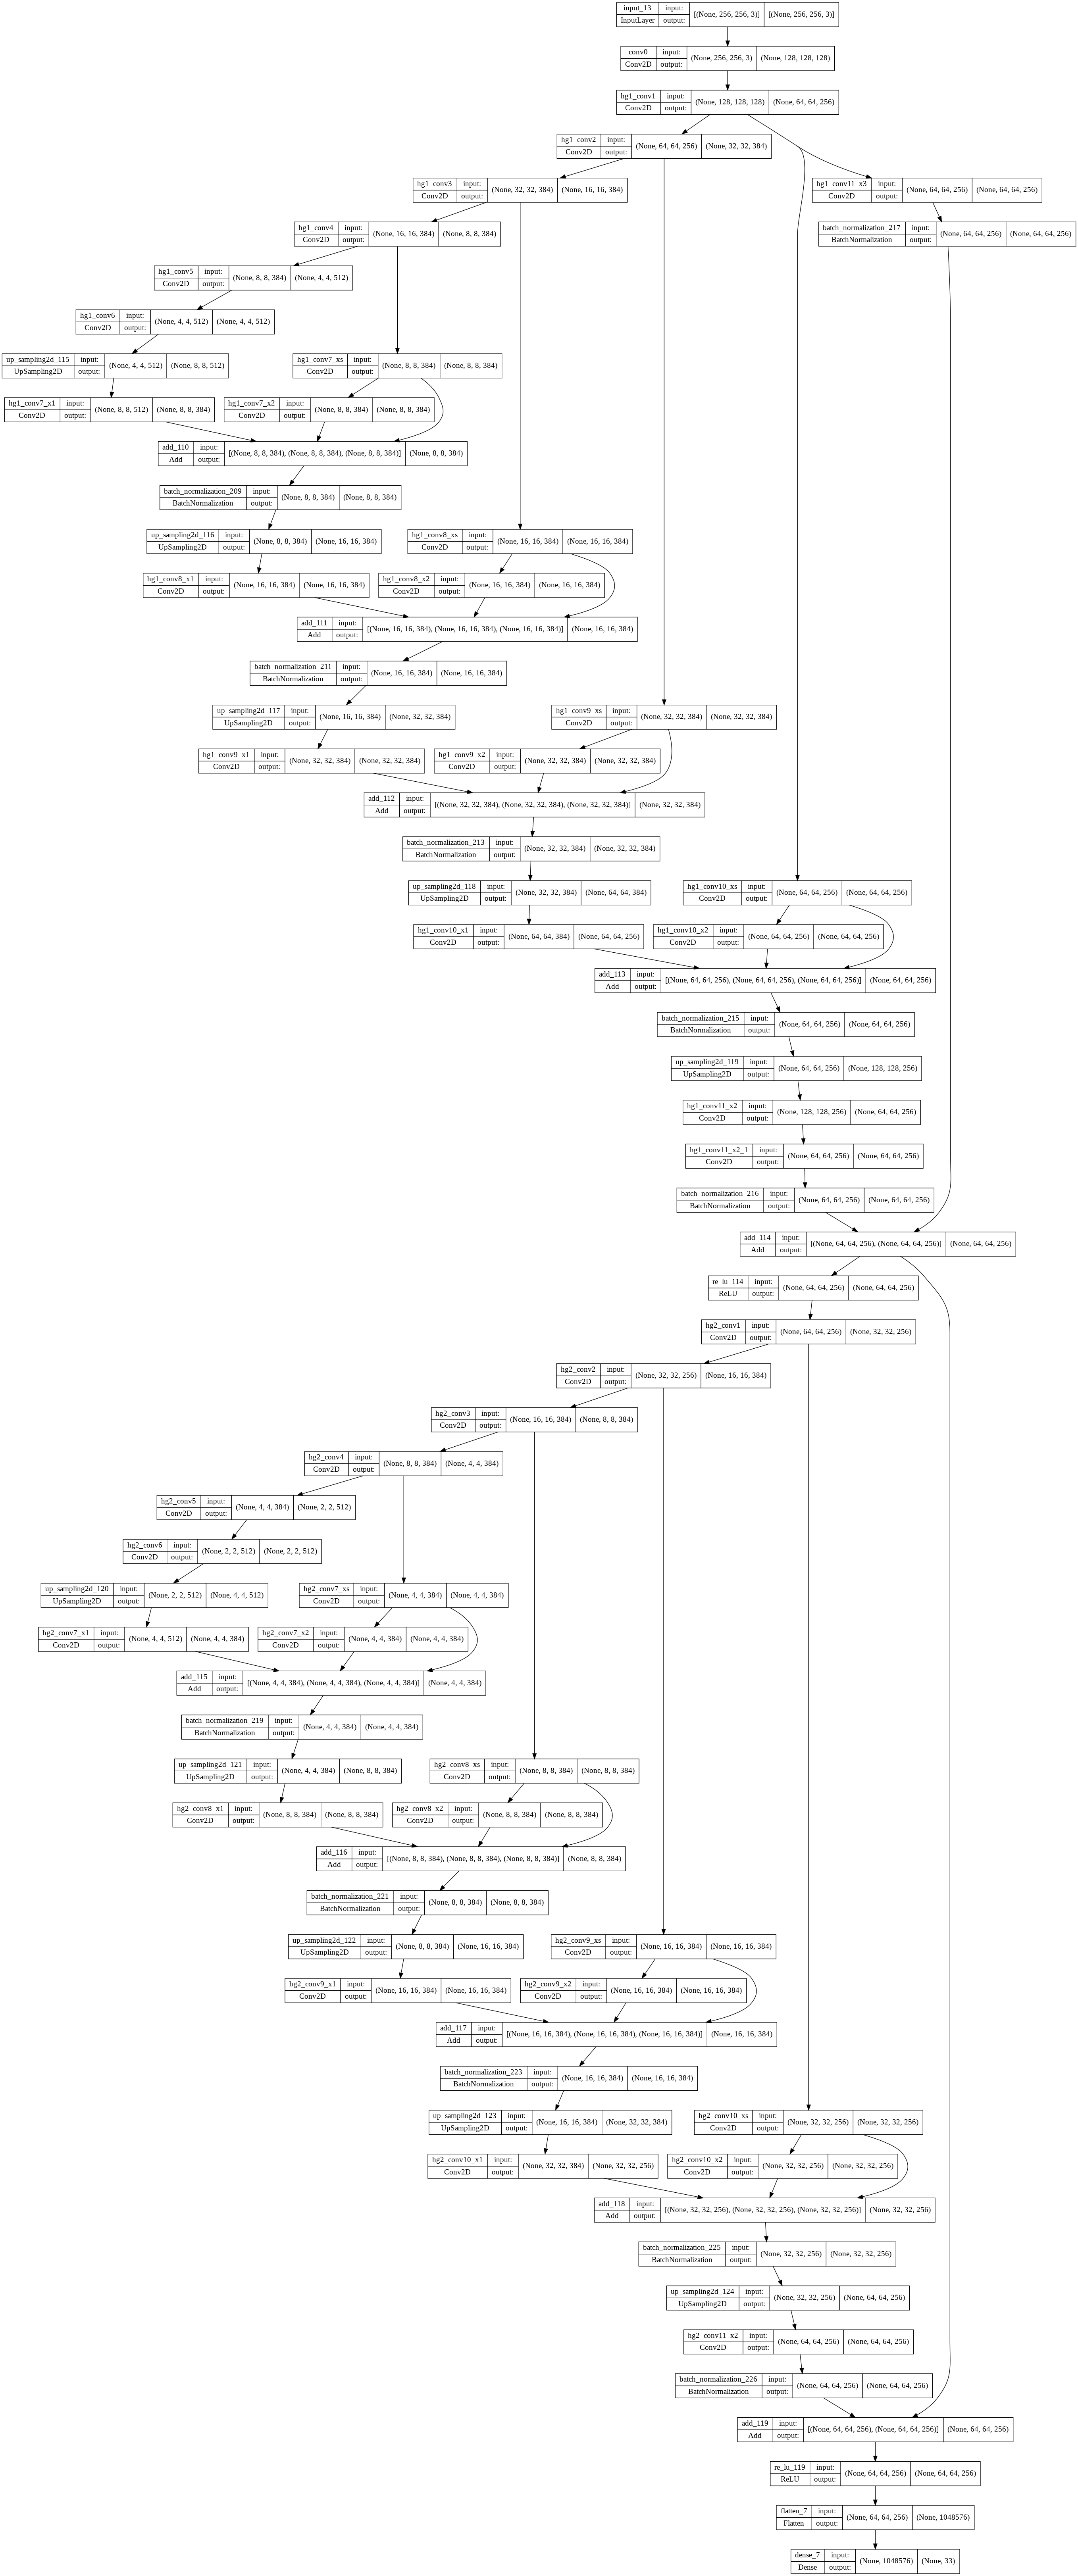

In [23]:
keras.utils.plot_model(model, "logonet.png", show_shapes=True)

In [24]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.RMSprop())
model.fit(train_generator, validation_data=validation_generator, epochs=5)

Epoch 1/5
173/173 [==============================] - 540s 3s/step - loss: 108.0679 - accuracy: 0.4955 - val_loss: 663.6039 - val_accuracy: 0.0795
Epoch 2/5
173/173 [==============================] - 461s 3s/step - loss: 5.0165 - accuracy: 0.5959 - val_loss: 242.8071 - val_accuracy: 0.7290
Epoch 3/5
173/173 [==============================] - 461s 3s/step - loss: 4.3028 - accuracy: 0.6468 - val_loss: 153.9875 - val_accuracy: 0.5792
Epoch 4/5
173/173 [==============================] - 461s 3s/step - loss: 2.2247 - accuracy: 0.7002 - val_loss: 123.5531 - val_accuracy: 0.7290
Epoch 5/5
173/173 [==============================] - 462s 3s/step - loss: 1.9161 - accuracy: 0.7218 - val_loss: 78.2686 - val_accuracy: 0.7290


In [ ]:
im = tf.keras.utils.load_img('/content/FlickrLogos-v2/classes/jpg/google/462663740.jpg')

x = tf.keras.utils.img_to_array(im)
x = tf.image.resize(x, [256, 256])
x = np.expand_dims(x, axis=0)
# images = np.vstack([x])
model.predict(x)[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
classes = np.array(list(train_generator.class_indices.keys()))
preds = model.predict(x)[0].astype(int)
classes[preds]

array(['HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP',
       'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP',
       'adidas', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP',
       'HP', 'HP'], dtype='<U12')

In [ ]:
!python FlickrLogos-v2/scripts/copy_images_to_flat_dir.py